In [6]:
import os
import json
from tqdm import tqdm
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from pprint import pprint

import sys
sys.path.append(str(Path.cwd().parent/'scripts'))

from _aggregation_helpers import flexible_aggregate

In [4]:
root = Path.cwd().parent / 'results'

In [5]:
periods = {}

# for fn in tqdm([p for p in os.listdir(root / 'periods') if '2023-01' in p]):
# for fn in tqdm([p for p in os.listdir(root / 'periods') if '2022-07' in p]):
#     with open(root / 'periods' / fn, 'r') as f:
#         periods.update(json.load(f))

with open(root / 'half-hourly' / '2023-04-05.json', 'r') as f:
    t = json.load(f)


In [16]:
agg = flexible_aggregate(t)

pprint(agg['nodal']['globals']['variables']['balancing_cost_savings'])
pprint(agg['eso']['globals']['variables']['balancing_cost_savings'])
pprint(agg['national']['globals']['variables']['balancing_cost_savings'])

2248169.5302581717
-65945.72324264207
0.0


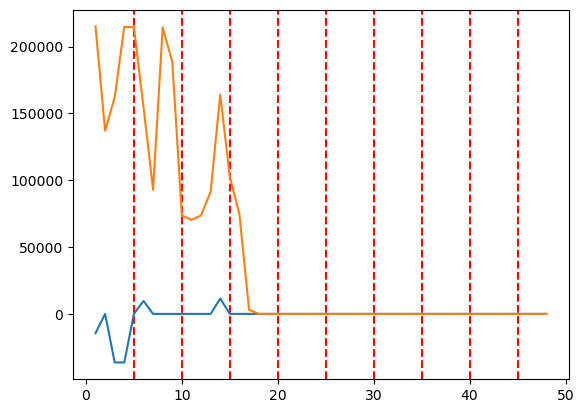

In [24]:
r = []
rn = []

for key, item in sorted(t.items()):
    r.append(item['eso']['globals']['variables']['balancing_cost_savings'])
    rn.append(item['nodal']['globals']['variables']['balancing_cost_savings'])

# dt = [pd.Timestamp.fromtimestamp(int(k)) for k in t.keys()]
dt = [i+1 for i in range(len(r))]

r = pd.Series(r, dt).sort_index()
rn = pd.Series(rn, dt).sort_index()

for l in range(5, 50, 5):
    plt.axvline(x=l, color='r', linestyle='--')

plt.plot(r.index, r.values)
plt.plot(rn.index, rn.values)

In [8]:
agg = flexible_aggregate(periods)

In [9]:
from pprint import pprint

pprint(agg['nodal']['globals'])
pprint(agg['eso']['globals'])
pprint(agg['national']['globals'])

{'variables': {'balancing_cost': 0.0,
               'balancing_cost_savings': 459512.49132648687,
               'cfd_cost': -231608.44894282715,
               'cfd_cost_savings': -203071.41352821485,
               'congestion_rent': -904417.5729748989,
               'congestion_rent_savings': 904417.5729790553,
               'wholesale_cost': 11338899.046410682,
               'wholesale_cost_savings': -62650.56478436105}}
{'variables': {'balancing_cost': 140362.85588154694,
               'balancing_cost_savings': 319149.6354449399,
               'cfd_cost': -202791.4662419687,
               'cfd_cost_savings': -231888.3962290733,
               'congestion_rent': -507152.3660840234,
               'congestion_rent_savings': 507152.3660881799,
               'wholesale_cost': 11336334.039771477,
               'wholesale_cost_savings': -60085.55814515613}}
{'variables': {'balancing_cost': 459512.49132648687,
               'balancing_cost_savings': 0.0,
               'cfd_cos

0.7385752688172043